<a href="https://colab.research.google.com/github/Probingbug/NN_from_scratch/blob/main/Combined_backpropogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are going to be 3 classes

1. Input layer class
2. ReLU class
3. softmax class



**Input layer class**

In [21]:
# dense layer
import numpy as np

class Layer_Dense:
  #Layer initialization
  def __init__(self, n_inputs, n_neurons):
    self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
    self.biases = np.zeros((1, n_neurons))

  #forward pass

  def forward(self, inputs):
    #remember input values
    self.inputs = inputs
    #calculate output values from inputs, weights and biases
    self.output = np.dot(inputs, self.weights) + self.biases

  def backward(self,dvalues):
    #gradients of parameters
    self.dweights = np.dot(self.inputs.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

    #gradient on values
    self.dinputs = np.dot(dvalues, self.weights.T)

**ReLU Class**

In [22]:
#ReLU activation

class Activation_ReLU:
  #forward pass
  def forward(self, inputs):
    self.inputs = inputs
    self.output = np.maximum(0, inputs)

  #backward pass

  def backward(self, dvalues):
    #since we need to modify original variable,
    #let's make a copy of values first
    self.dinputs = dvalues.copy()
    #zero gradient where input values were negative
    self.dinputs[self.inputs <= 0] = 0


**Combined softmax and cross entropy loss**



In [42]:
class Activation_Softmax_Loss_CategoricalCrossentropy:
  #creates activation and loss function objects
  def __init__(self):
    self.activation = Activation_Softmax()
    self.loss = Loss_CategoricalCrossentropy()

  def forward_pass(self,inputs,y_true):
    self.activation.forward(inputs)
    self.output = self.activation.output
    if y_true is not None:
      return self.loss.calculate(self.output, y_true)
    # If y_true is None, we don't calculate loss, just the activation output
    return None


  def backward_pass(self,dvalues,y_true):
    samples = len(dvalues)
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true, axis=1)

    self.dinputs = dvalues.copy()
    self.dinputs[range(samples), y_true] -= 1
    self.dinputs = self.dinputs / samples

In [24]:
# Softmax activation
class Activation_Softmax:
  # Forward pass
  def forward(self, inputs):
    # Get unnormalized probabilities
    exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    self.output = probabilities

  # Backward pass (unchanged for now)
  def backward(self, dvalues):
    # This is handled in the combined Softmax and loss class
    pass

**Categorical Crossentropy Loss**

In [25]:
# Loss function
class Loss:
  # Calculate the loss
  def calculate(self, output, y_true):
    # Calculate sample losses
    sample_losses = self.forward(output, y_true)
    # Calculate mean loss
    data_loss = np.mean(sample_losses)
    return data_loss

# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
  # Forward pass
  def forward(self, y_pred, y_true):
    # Clip data to prevent division by 0
    # Clip both sides to not drag mean towards any value
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    # Probabilities for target values -
    # only if categorical labels
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[
        range(len(y_pred_clipped)),
        y_true
      ]
    # Mask values - only for one-hot encoded labels
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(
        y_pred_clipped * y_true,
        axis=1
      )

    # Losses
    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods

  # Backward pass (unchanged for now)
  def backward(self, dvalues, y_true):
    # Number of samples
    samples = len(dvalues)
    # Number of labels in every sample
    # We'll use the first sample to count them
    labels = len(dvalues[0])

    # If labels are sparse, turn them into one-hot vector
    if len(y_true.shape) == 1:
      y_true = np.eye(labels)[y_true]

    # Calculate gradient
    self.dinputs = -y_true / dvalues
    # Normalize gradient
    self.dinputs = self.dinputs / samples

In [26]:
!pip install nnfs


**Dataset**

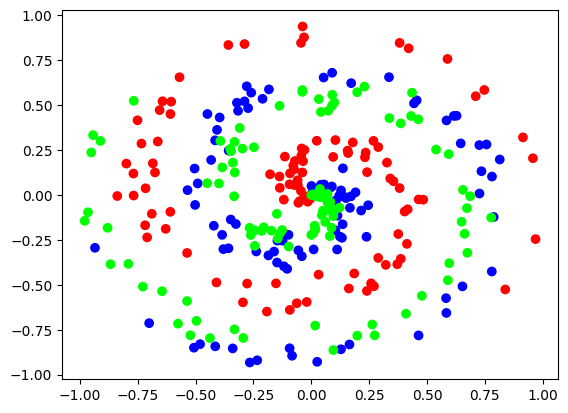

In [27]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
import matplotlib.pyplot as plt

nnfs.init()
X, y = spiral_data(samples=100,classes = 3)

plt.scatter( X[:,0],X[:,1], c = y, cmap = 'brg')
plt.show()

**FULL CODE UPTO THIS POINT : FORWARD AND BACKWARD PASS**

In [28]:
#create dataset

X,y = spiral_data(samples = 100, classes = 3)
#create dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2,3)
#create ReLU activation (to be used with dense layer)
activation1 = Activation_ReLU()
#create second Dense layer with three input and three outputs
dense2 = Layer_Dense(3,3)
#create loss function
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
#perform a forward pass through activation function
dense1.forward(X)
# perform a forward pass through activation function
#takes the output of first dense layer here

activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward_pass(dense2.output, y)
# let's see output of the first few samples:
print(loss_activation.output[:5])
print('loss :',loss)



#calculate accuracy from output of activation2 and targets
#calculate values along first axis
predictions = np.argmax(loss_activation.output, axis = 1)
if len(y.shape) == 2:
  y = np.argmax(y, axis = 1)
accuracy = np.mean(predictions == y)
#print accuracy

print('acc:',accuracy)

#backward pass

loss_activation.backward_pass(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

#print gradients

print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.3333333  0.33333334]
 [0.3333335  0.333333   0.33333352]
 [0.33333334 0.33333334 0.33333334]]
loss : 1.0986118
acc: 0.33666666666666667
[[ 7.7209341e-05 -1.0590541e-04 -8.3512561e-05]
 [ 2.8525142e-04  6.1521474e-05 -9.9994701e-05]]
[[ 0.00036935 -0.00025332  0.00021116]]
[[ 1.0425548e-04  1.5916037e-05 -1.2017150e-04]
 [-4.9149978e-05  1.9419583e-04 -1.4504585e-04]
 [ 3.6147623e-05  1.0825427e-04 -1.4440189e-04]]
[[ 1.0384247e-05 -1.0518939e-05  3.9814040e-08]]


**OPTIMIZERS GRADIENT DESCENT**

In [30]:
class optimizer_GD:
  def __init__(self,learning_rate=1.0):
    self.learning_rate = learning_rate
    #update parameters
  def update_params(self,layer):
    layer.weights += -self.learning_rate * layer.dweights
    layer.biases += -self.learning_rate * layer.dbiases

In [33]:
#create dataset
X,y =spiral_data(samples = 100, classes = 3)

#create dense layer with 2 input features and 64 output values

dense1 = Layer_Dense(2,64)
#create ReLU activation (to be used with dense layer)
activation1 = Activation_ReLU()

#create second Dense layer with 64 input and 3 outputs
dense2 = Layer_Dense(64,3)

#create softmax classifies's combined loss and activation

loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#create optimizer
optimizer = optimizer_GD(learning_rate=1)

#train in loops

for epoch in range(100001):
  #Perform a forward pass of our trianing data through this layer
  dense1.forward(X)

  #Perform a forward pass through activation function
  #takes the output of first dense layer here
  activation1.forward(dense1.output)
  #perform a forward pass through second Dense layer
  dense2.forward(activation1.output)
  #perform a forward pass through the activation/loss function
  #takes the output of second dense layer here and returns loss
  loss = loss_activation.forward_pass(dense2.output, y)

  #calculate the accuract from output of activation2 and targets
  #calculate values along first axis
  predictions = np.argmax(loss_activation.output, axis = 1)
  if len(y.shape) == 2:
    y = np.argmax(y, axis = 1)

  accuracy = np.mean(predictions == y)
  if not epoch % 10000:
    print(f'epoch: {epoch}, ' +
          f'acc: {accuracy:.3f}, ' +
          f'loss: {loss:.3f}, ' )

  #backward pass

  loss_activation.backward_pass(loss_activation.output, y)
  dense2.backward(loss_activation.dinputs)
  activation1.backward(dense2.dinputs)
  dense1.backward(activation1.dinputs)

  #update weights and biases
  optimizer.update_params(dense1)
  optimizer.update_params(dense2)



epoch: 0, acc: 0.287, loss: 1.099, 
epoch: 10000, acc: 0.397, loss: 3.863, 
epoch: 20000, acc: 0.820, loss: 0.414, 
epoch: 30000, acc: 0.833, loss: 0.447, 
epoch: 40000, acc: 0.873, loss: 0.432, 
epoch: 50000, acc: 0.890, loss: 0.289, 
epoch: 60000, acc: 0.900, loss: 0.231, 
epoch: 70000, acc: 0.903, loss: 0.199, 
epoch: 80000, acc: 0.903, loss: 0.212, 
epoch: 90000, acc: 0.920, loss: 0.170, 
epoch: 100000, acc: 0.920, loss: 0.164, 


In [43]:
def visualize_decision_boundary(model_layers, X, y, step=0.01):
    """
    Visualize decision boundaries of a trained model.

    Parameters:
        model_layers (list): A list of model layers in forward order.
                             e.g., [dense1, activation1, dense2, loss_activation]
        X (ndarray): Input feature data (2D).
        y (ndarray): True labels.
        step (float): Step size for meshgrid.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Define the range of the plot
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Pass through model
    current_output = grid
    for layer in model_layers:
        layer.forward(current_output)
        current_output = layer.output

    predictions = np.argmax(current_output, axis=1)
    Z = predictions.reshape(xx.shape)

    # Plot decision boundary and data
    plt.contourf(xx, yy, Z, cmap='brg', alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=20, edgecolors='k')
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

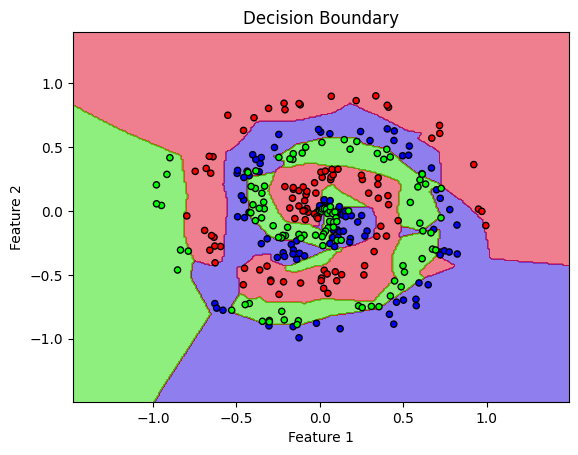

In [44]:
visualize_decision_boundary(
    [dense1, activation1, dense2, loss_activation.activation], X, y
)